In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from pathlib import Path
import os
import random
from PIL import Image
import os
import PIL
import splitfolders


In [10]:
# podział pliku na dwie części, w celu odzielenia pliku testowego
splitfolders.ratio('data', output="output", seed=1337, ratio=(.9, 0, 0.1))


Copying files: 1896 files [00:05, 338.45 files/s]


In [15]:
# ścieka do pliku z danymi
data_dir = Path("output/train")


In [12]:
# parametry do załadowania plików
batch_size = 32
img_height = 180
img_width = 180


In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=100,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 1706 files belonging to 2 classes.
Using 1365 files for training.


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=100,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 1706 files belonging to 2 classes.
Using 341 files for validation.


In [18]:
# nazwy klas
class_names = train_ds.class_names
print(class_names)


['Fresh', 'Spoiled']


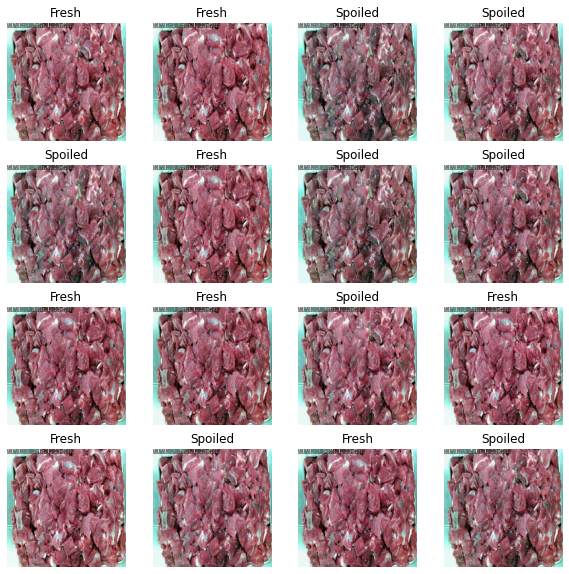

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [20]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

# 1 batch to 32 obrazy o rozmiarach 180x180


(32, 180, 180, 3)
(32,)


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [22]:
# standaryzacja danych, wartości mają się mieścić w przedziale od 0 do 1.
normalization_layer = layers.Rescaling(1./255)


In [23]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [24]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])


In [27]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [30]:
epochs = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10
43/43 [==============================] - 39s 919ms/step - loss: 0.0408 - accuracy: 0.9846 - val_loss: 0.0179 - val_accuracy: 0.9971
Epoch 2/10
43/43 [==============================] - 28s 649ms/step - loss: 0.0231 - accuracy: 0.9890 - val_loss: 0.0130 - val_accuracy: 0.9971
Epoch 3/10
43/43 [==============================] - 28s 662ms/step - loss: 0.0128 - accuracy: 0.9956 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 4/10
43/43 [==============================] - 29s 666ms/step - loss: 0.0081 - accuracy: 0.9993 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 5/10
43/43 [==============================] - 28s 660ms/step - loss: 0.0050 - accuracy: 0.9993 - val_loss: 0.0070 - val_accuracy: 0.9971
Epoch 6/10
43/43 [==============================] - 33s 762ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 7/10
43/43 [==============================] - 24s 546ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000

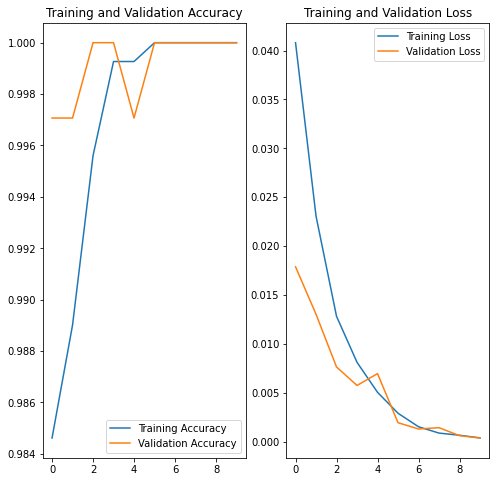

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [32]:
print('Evaluate Model....')
ev = model.evaluate(val_ds, return_dict=True)
print(ev)


Evaluate Model....
11/11 [==============================] - 2s 214ms/step - loss: 3.6986e-04 - accuracy: 1.0000
{'loss': 0.00036986442864872515, 'accuracy': 1.0}


In [33]:
preds = model.predict(val_ds, verbose=1)
preds[:5]


11/11 [==============================] - 3s 227ms/step


array([[ -8.977238 ,   7.073209 ],
       [ -8.473236 ,   6.7521   ],
       [ -3.8757603,   2.9333794],
       [ -7.664096 ,   6.032646 ],
       [ 11.445999 , -10.210797 ]], dtype=float32)

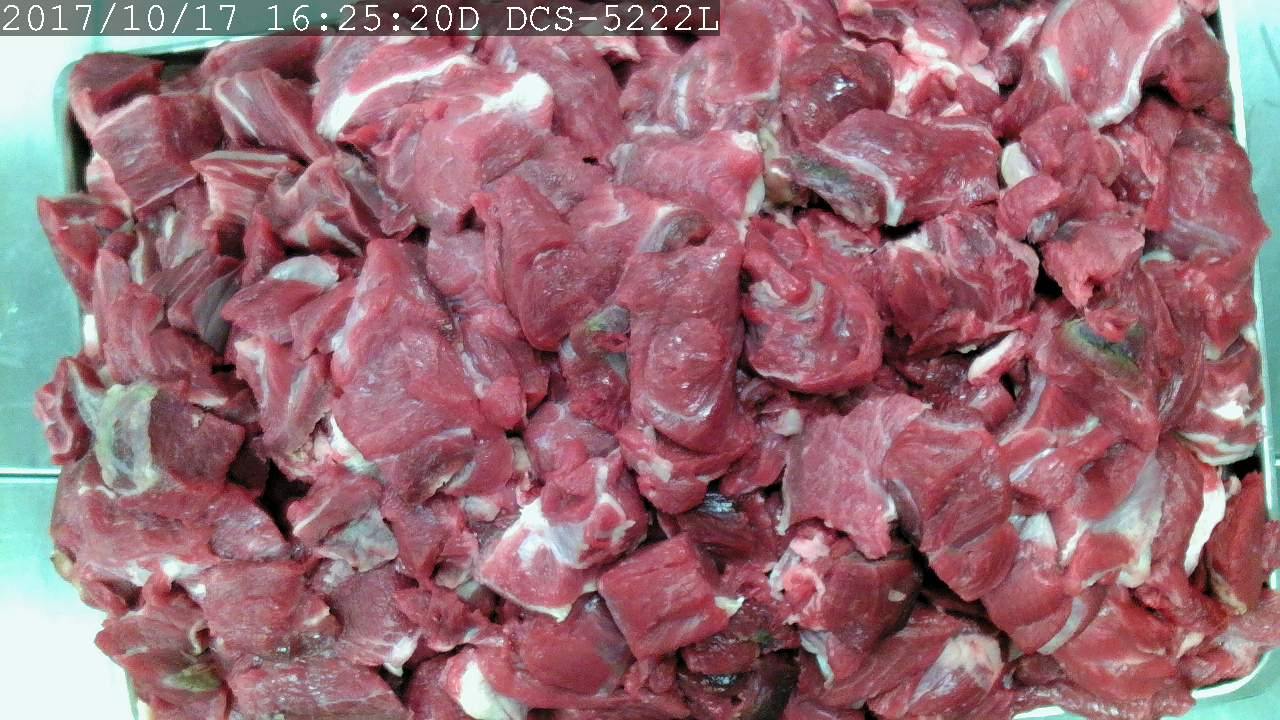

In [34]:
# losowanie zdjecia ze zbioru zdjęć świezych
path = str(random.choice(os.listdir("output/test/Fresh/")))
image_fresh = Image.open("output/test/Fresh/"+path)
resized_image_fresh = image_fresh.resize((180, 180))
image_fresh


In [35]:
img_array = tf.keras.utils.img_to_array(resized_image_fresh)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to Fresh with a 99.77 percent confidence.


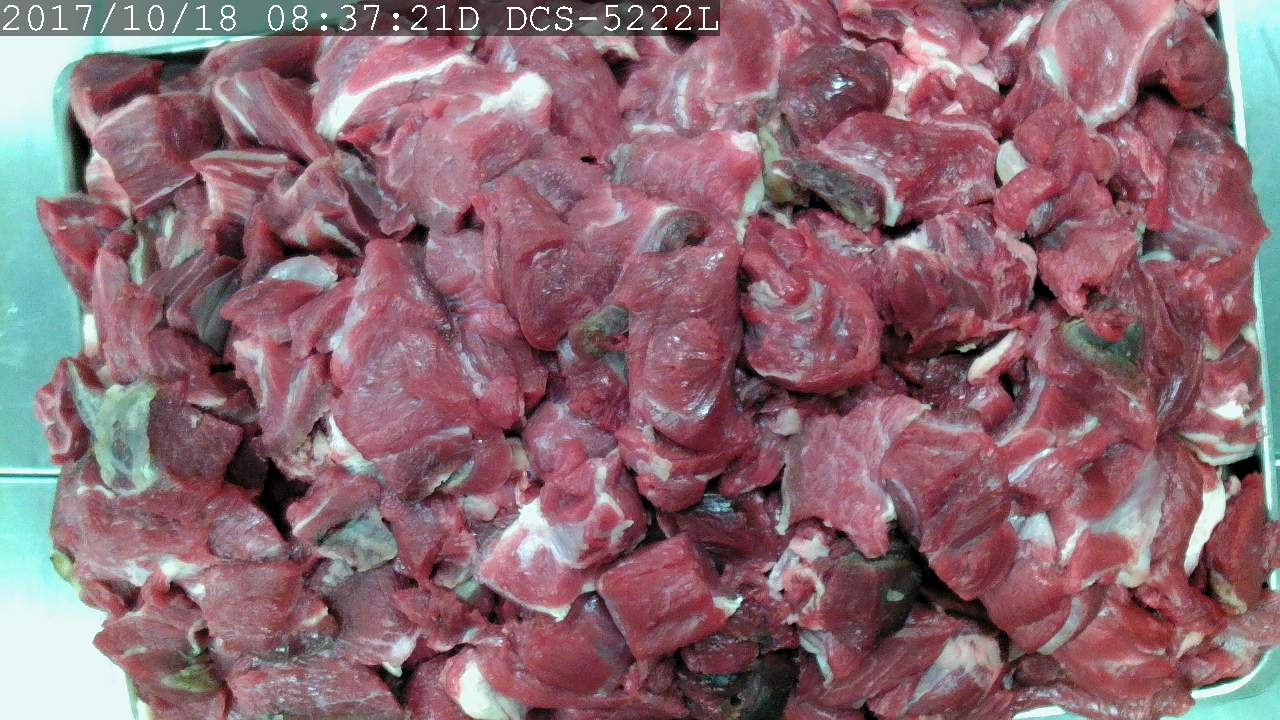

In [36]:
# losowanie zdjecia ze zbioru zdjęć świezych
path = str(random.choice(os.listdir("output/test/Spoiled/")))
image_spoiled = Image.open("output/test/Spoiled/"+path)
resized_image_spoiled = image_spoiled.resize((180, 180))
image_spoiled


In [37]:
img_array = tf.keras.utils.img_to_array(resized_image_spoiled)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to Spoiled with a 99.99 percent confidence.
